In [1]:
#import geomstats




In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)

import numpy as np

# Clustering of mixture families

### Example for mixture families
Gauss:
$p_0(x;\mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2 \sigma^2}\right)$

Cauchy:
$p_1(x;\mu, \gamma) = \frac{1}{\pi} \frac{\gamma}{\gamma^2 + (x - \mu)^2}$

Laplace:
$p_2(x;\mu, b) = \frac{1}{2b} \exp\left( -\frac{|x-\mu|}{b} \right)$


$\rightarrow m(x; \eta) = \eta_1 p_1 + \eta_2 p_2 + (1-\eta_1-\eta_2) p_0$

In [3]:
def gauss(x, mu, sigma):
    return np.exp(-((x - mu)**2) / (2 * sigma**2)) * (1 / (sigma * np.sqrt(2 * np.pi)))

def laplace(x, mu, b):
    return np.exp(-abs(x - mu) / b) / (2 * b)

def cauchy(x, mu, gamma):
    return 1/np.pi * gamma / ((x - mu)**2 + gamma**2)

def m(X, m1, m2):
    return m1*cauchy(X, 0, 1) + m2*laplace(X, 3, 1) + (1-m1-m2)*gauss(X, -3, 1)

X = np.linspace(-7, 7, 200)
def f(m1, m2 ):
    plt.plot(X, gauss(X, -3, 1), label='$p_0$ gauss')
    plt.plot(X, cauchy(X, 0, 1), label='$p_2$ cauchy')
    plt.plot(X, laplace(X, 3, 1), label='$p_3$ laplace')
    plt.plot(X, m(X, m1, m2), 'black', label='mixture')
    plt.legend()

# interact with sliders
interact(f, m1=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.33), m2=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.33));


interactive(children=(FloatSlider(value=0.33, description='m1', max=1.0, step=0.01), FloatSlider(value=0.33, d…

#### Generate data from arbitrary mixture

In [4]:
N = 1000

#choose arbitrary mixture to fit
m1= 0.1
m2= 0.5
prob = mixture(X, m1, m2)
prob_norm = prob/sum(prob) #normalize
data = np.random.choice(X, p=prob_norm, size=N)
plt.hist(data, bins=30, density=True);

NameError: name 'mixture' is not defined

#### Estimating $B_G$

Notice that $F$ in our case is the ideal negative Shannon entropy:
$$G(\eta) = -h(m(x;\eta)) = \int_{x \in \mathcal{X}} m(x;\eta) \log m(x;\eta) \text{d} \mu (x)$$

We however want to estimate it by using a finite data $S \subset \mathcal{X}$:

$$G(\eta) \approx \tilde{G}_S (\eta) = \frac{1}{m} \sum_{i=1}^m \frac{1}{q(x_i)} \, m(x_i;\eta) \log m(x_i;\eta) $$
where $m= |S|$ and $q(x)$ is the fixed proposal distribution. 

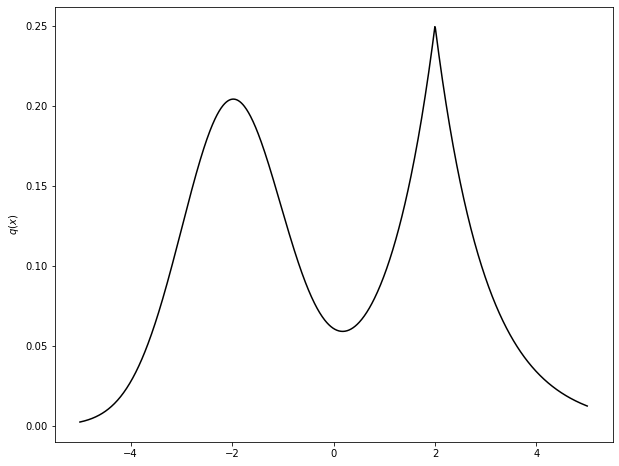

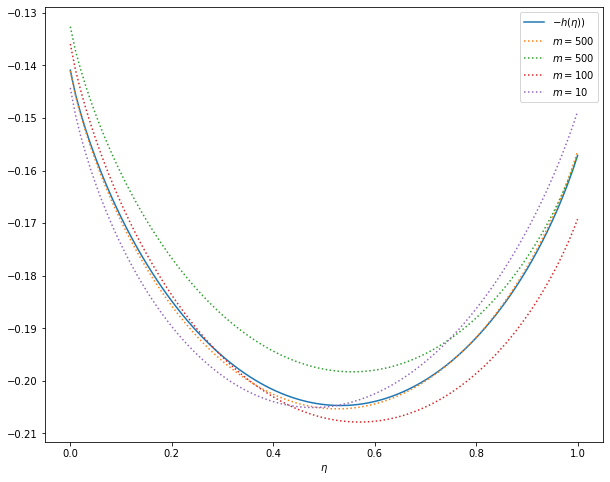

In [ ]:
def m(X, eta):
    return (1-eta)*gauss(X, -2,1) + eta*laplace(X, 2, 1)

def shannon_negentropy(X, eta):
    results = []
    for e in eta:
        results.append(np.sum(m(X, e)*np.log(m(X, e)))/len(X))
    return results

def mc_G(X, eta, eta_q):
    results = []
    for e in eta:
        r = np.sum(m(X, e)*np.log(m(X, e))/m(X,eta_q))/len(X)
        results.append(r)
    return results

def reduce_to_N_supports(X, N):
    import random
    random.shuffle(X)
    return X[:N]


eta_q = 0.5

X = np.linspace(-5,5,1000)
plt.plot(X, m(X, eta_q), 'black')
plt.ylabel('$q(x)$')
plt.show()

eta = np.linspace(0,1,100)
plt.plot(eta, shannon_negentropy(X, eta), label="$-h(\eta)$)")
plt.plot(eta, shannon_negentropy(reduce_to_N_supports(X, 750), eta),":", label="$m=500$")
plt.plot(eta, shannon_negentropy(reduce_to_N_supports(X, 500), eta),":", label="$m=500$")
plt.plot(eta, shannon_negentropy(reduce_to_N_supports(X,100), eta),":", label="$m=100$")
plt.plot(eta, shannon_negentropy(reduce_to_N_supports(X,10), eta),":", label="$m=10$")
plt.legend()
plt.xlabel("$\eta$")
plt.show();

#### Bregman Voronoi clustering

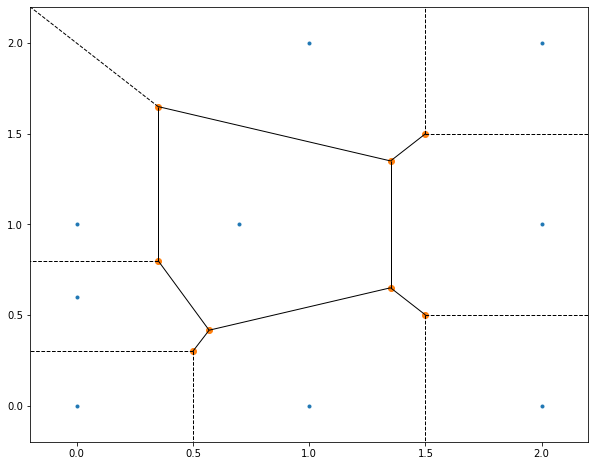

In [ ]:
points = np.array([[0, 0], [0, 1], [0, 0.6], [1, 0], [0.7, 1], [1, 2], [2, 0], [2, 1], [2, 2]])
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)

fig = voronoi_plot_2d(vor)
plt.show();

To approximate the dual coordinate system $\theta$ we use
$$\theta_1 = \partial_1 G(\eta) \approx \partial_1 \tilde{G}_S (\eta) = \frac{1}{m} \sum_{i=1}^m \frac{1}{q(x_i)}(p_1(x_i)-p_0(x_i)) (1+\log m(x_i;\eta)) $$
$$\theta_2 = \partial_2 G(\eta) \approx \partial_2 \tilde{G}_S (\eta) = \frac{1}{m} \sum_{i=1}^m \frac{1}{q(x_i)}(p_2(x_i)-p_0(x_i)) (1+\log m(x_i;\eta)) $$

Then we draw a Laguerre-Voronoi diagram, according to https://arxiv.org/pdf/0709.2196.pdf (4.3)
$$<x-\theta, x-\theta> = <\theta, \theta> + 2(\tilde{G}_S(\eta) - <\eta, \theta>)$$ 
which in turn leads to the wanted Voronoi diagram for our mixture in $\eta$ coordinates.


We draw the Laguerre-Voronoi diagram using a tool from github: https://gist.github.com/marmakoide/45d5389252683ae09c2df49d0548a627#file-laguerre-voronoi-2d-py

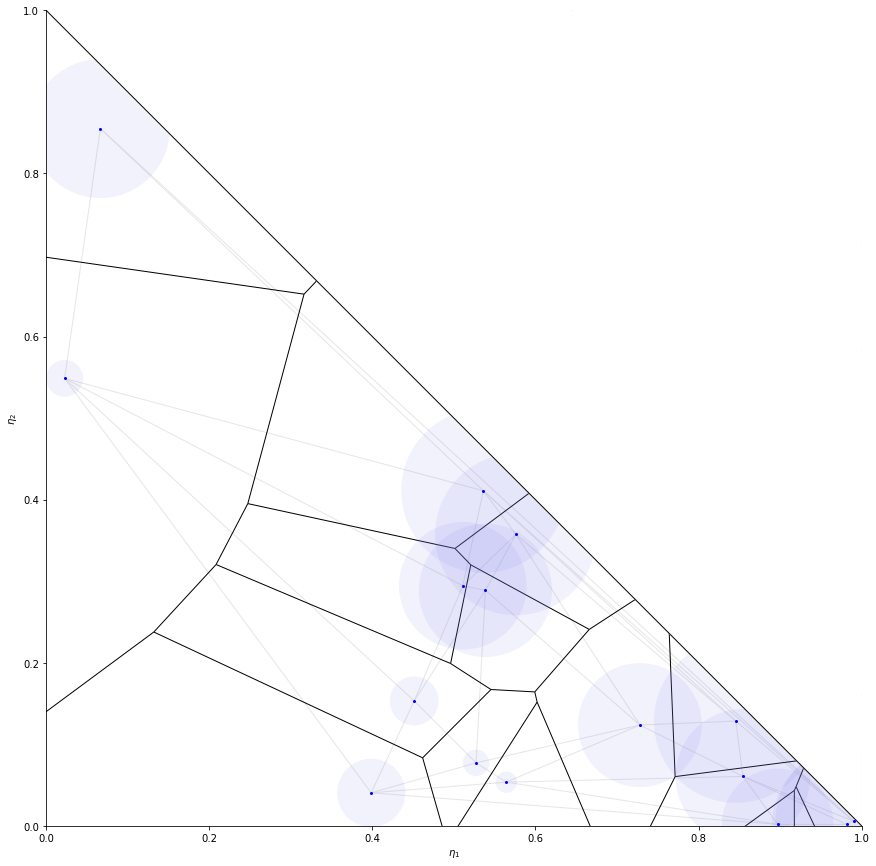

In [48]:
plt.rcParams["figure.figsize"] = (15,15)

def p1(X):
    return cauchy(X, 0, 1)

def p0(X):
    return gauss(X, -3, 1)

def p2(X):
    return laplace(X, 3, 1)

def m(X, eta):
    return eta[0]*p1(X) + eta[1]*p2(X) + (1-eta[0]-eta[1])*p0(X)

"""In practice, the proposal distribution q(x) can be chosen as the uniform mixture of the fixed component
distributions"""
def q(X):    
    return m(X, [1/3, 1/3])

# eta is a vector of length 2 now!
def mc_G(X, eta):
    return np.sum(m(X, eta)*np.log(m(X, eta))/q(X))/len(X)


def mc_dG(X, eta):
    """Derivative of G to get dual coordinates: theta = dG(eta)"""
    dG1 = np.sum(1/q(X) * (p1(X)-p0(X)) * (1+np.log(m(X,eta))) )/len(X)
    dG2 = np.sum(1/q(X) * (p2(X)-p0(X)) * (1+np.log(m(X,eta))) )/len(X)
    return [dG1,dG2]

# generate example mixtures
N = 16
eta1 = np.random.uniform(0,1,N)
eta2 = np.random.uniform(0,1-eta1,N)
eta = np.array([eta1, eta2]).transpose()

# get theta from derivatives of G
theta = np.array([mc_dG(X, [eta1[i], eta2[i]]) for i in range(N)])


weights = np.array([( np.inner(theta[i], theta[i]) 
                     + 2*(mc_G(X,eta[i]) -np.inner(theta[i], eta[i])) 
                    ) for i in range(N)])
# TODO: subtract minimal weight?

#weights -= np.min(weights)
weights /= np.sum(weights)


import importlib  
lv = importlib.import_module("laguerre-voronoi-2d")
lv = importlib.reload(lv)


tri_list, V = lv.get_power_triangulation(eta, weights)

#compute the voronoi cells
voronoi_cell_map = lv.get_voronoi_cells(eta, V, tri_list)




ax = plt.subplot(111)
plt.xlabel("$\eta_1$")
plt.ylabel("$\eta_2$")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.gca().set_aspect('equal', adjustable='box')
plt.axline((1, 0), (0, 1), color="black", linewidth=1)




for i in range(len(eta1)):
    plt.plot(eta1[i], eta2[i], 'o', markersize=2, color="blue")

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# display laguerre-voronoi diagram
lv.display(eta, weights, tri_list, voronoi_cell_map, ax)

#cover accidents:
t = plt.Polygon(np.array([[1,0],[0,1],[1,1]]), color="white")
plt.gca().add_patch(t)

plt.show();